In [38]:
import pandas as pd
from sklearn import tree, svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import pickle
from dtree_skin_segmentation import RGB_TO_HSI, load_rgb_image
import numpy as np
import matplotlib.pyplot as plt
import cv2

model_loc = "./Dataset/dtree_additional_images2.sav"
old_model = "./Dataset/dtree_140_images.sav"
do_training = True

In [39]:
skin_dataset = pd.read_csv("./Dataset/pixelwise_skin_and_burn_trial.csv")

skin_dataset2 = pd.read_csv("./Dataset/additional_data.csv")
skin_dataset = pd.concat([skin_dataset, skin_dataset2], axis=0, ignore_index=True)

skin_dataset3 = pd.read_csv("./Dataset/additional_data2.csv")
skin_dataset = pd.concat([skin_dataset, skin_dataset3], axis=0, ignore_index=True)

skin_dataset = skin_dataset.dropna()
X = skin_dataset.iloc[:,:-1]
y = skin_dataset.iloc[:,-1]

In [40]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]

In [41]:
if do_training:
    model_scores = []
    models = []
    fold_num = 0
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        fold_num += 1
        print("Fold:", fold_num)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        #print(X_train)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]# split()  method generate indices to split data into training and test set.
        print("Dtree")
        dtree = tree.DecisionTreeClassifier()
        dtree = dtree.fit(X_train.values, y_train.values)
        score1 = dtree.score(X_test.values, y_test.values)
        models.append(dtree)
        model_scores.append(score1)

        # Commented out for a while because it takes a long time
        # print("SVC")
        # svm_model = svm.SVC(gamma='auto')
        # svm_model = svm_model.fit(X_train.values, y_train.values)
        # score2 = svm_model.score(X_test.values, y_test.values)
        # models.append(svm_model)
        # model_scores.append(score2)

        # print("Linear Regression")
        # reg = LinearRegression().fit(X_train.values, y_train.values)
        # score3 = reg.score(X_test.values, y_test.values)
        # models.append(reg)
        # model_scores.append(score3)
        #
        # print("KNN")
        # neigh = KNeighborsClassifier(n_neighbors=3)
        # neigh = neigh.fit(X_train.values, y_train.values)
        # score4 = neigh.score(X_test.values, y_test.values)
        # models.append(neigh)
        # model_scores.append(score4)

    max_value = max(model_scores)
    max_index = model_scores.index(max_value)
    pickle.dump(models[max_index], open(model_loc, 'wb'))
    #print(len(models))

Fold: 1
Dtree
Fold: 2
Dtree
Fold: 3
Dtree
Fold: 4
Dtree
Fold: 5
Dtree


In [42]:
def segment_image(rgb_image, model_filename, grayscale=True):
    loaded_model = pickle.load(open(model_filename, 'rb'))
    print("Loaded Model is:", model_loc)
    grayscale_out = rgb_image.copy()
    rgb_out = rgb_image.copy()
    test_image_hsi = RGB_TO_HSI(rgb_out)
    for row in range(0, test_image_hsi.shape[1]):
        for col in range(0, test_image_hsi.shape[0]):
            if np.isnan(test_image_hsi[row,col][0]):
                rgb_out[row,col] = (0, 0, 0)
                continue
            else:
                prediction = loaded_model.predict([test_image_hsi[row,col]])
                if prediction == 0:
                    grayscale_out[row,col] = (0, 0, 0)
                    rgb_out[row,col] = (0, 0, 0)
                elif prediction == 1:
                    grayscale_out[row,col] = (125, 125, 125)
                elif prediction == 2:
                    grayscale_out[row,col] = (250, 250, 250)
    if grayscale:
        return grayscale_out
    else:
        return rgb_out

In [43]:
def image_masks(rgb_image, model_filename, aggression=0.9):
    loaded_model = pickle.load(open(model_filename, 'rb'))
    print("Loaded Model is:", model_loc)
    background = np.zeros(rgb_image.shape[:2])
    skin = np.zeros(rgb_image.shape[:2])
    burn = np.zeros(rgb_image.shape[:2])

    test_image_hsi = RGB_TO_HSI(rgb_image)
    for row in range(0, test_image_hsi.shape[1]):
        for col in range(0, test_image_hsi.shape[0]):
            if np.isnan(test_image_hsi[row,col][0]):
                background[row,col] = 1
            else:
                prediction = loaded_model.predict([test_image_hsi[row,col]])
                score = loaded_model.predict_proba([test_image_hsi[row,col]])
                if prediction == 0:
                    background[row,col] = 1
                elif prediction == 1 and score[0][1] > aggression:
                    skin[row,col] = 1
                    #print("Skin Score:", score)
                elif prediction == 2 and score[0][2] > aggression:
                    burn[row,col] = 1
                    #print("Burn Score:", score)
                else:
                    background[row,col] = 1
    return background, skin, burn


In [44]:
def dilate_and_erode(mask, erosion=4, dilation=2):
    img_dilation = cv2.dilate(mask,np.ones((3,3),
                            np.uint8),iterations=dilation)
    # blurred = cv2.GaussianBlur(img_dilation,(7,7),
    #                            cv2.BORDER_DEFAULT).astype('uint8')
    img_erosion = cv2.erode(img_dilation, np.ones((3,3),
                            np.uint8), iterations=erosion)
    return img_erosion

def erode_and_dilation(mask, erosion=2, dilation=3):
    img_erosion = cv2.erode(mask,
                            np.ones((3,3), np.uint8), iterations=erosion)
    img_dilation = cv2.dilate(img_erosion,
                              np.ones((3,3), np.uint8),iterations=dilation)
    # blurred = cv2.GaussianBlur(img_dilation,(7,7),
    #                            cv2.BORDER_DEFAULT).astype('uint8')
    return img_dilation

In [45]:
def skin_overlay(rgb_image, model_filename, remove_background=False,
                 burn_only=False,
                 return_mask=False, aggression=0.5, skin_dilation=2,
                 skin_erosion=4, burn_dilation=2, burn_erosion=4):
    rgb_copy = rgb_image.copy()
    background, skin, burn = image_masks(rgb_image,
                                         model_filename=model_filename,
                                         aggression=aggression)
    background_processed = erode_and_dilation(background)
    skin_processed = dilate_and_erode(skin, dilation=skin_dilation, erosion=skin_erosion)
    burn_processed = dilate_and_erode(burn, dilation=burn_dilation, erosion=burn_erosion)
    class_mask = np.zeros(rgb_image.shape[:2])
    img_copy = np.zeros(rgb_image.shape)

    for row in range(0,img_copy.shape[1]):
        for col in range(0,img_copy.shape[0]):
            if burn_processed[row,col] > 0:
                img_copy[row,col] = (255, 0, 0)
                class_mask[row,col] = 2
            elif skin_processed[row,col] > 0:
                img_copy[row,col] = (0, 255, 0)
                class_mask[row,col] = 1
                if burn_only:
                    rgb_copy[row,col] = (0, 0, 0)
            elif background_processed[row,col] > 0:
                img_copy[row,col] = (0, 0, 0)
                class_mask[row,col] = 0
                if remove_background or burn_only:
                    rgb_copy[row,col] = (0, 0, 0)
    if remove_background or burn_only:
        fused_img = rgb_copy
    else:
        img_copy_converted = img_copy.astype('uint8')
        fused_img = cv2.addWeighted(rgb_copy, 0.8, img_copy_converted, 0.2, 0)

    if return_mask:
        return fused_img, class_mask
    else:
        return fused_img

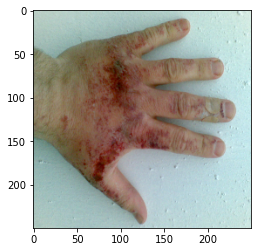

In [46]:
test_img = "./Dataset/full_coco/images/img3.jpg"
rgb_image = load_rgb_image(test_img)
plt.imshow(rgb_image)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


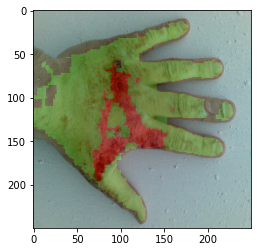

In [47]:
fused_img = skin_overlay(rgb_image, model_loc)
plt.imshow(fused_img)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


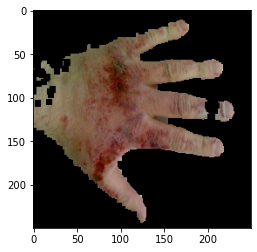

In [48]:
fused_img = skin_overlay(rgb_image, model_loc, remove_background=True)
plt.imshow(fused_img)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


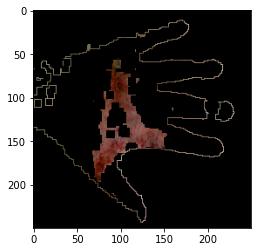

In [49]:
fused_img = skin_overlay(rgb_image, model_loc, remove_background=True, burn_only=True)
plt.imshow(fused_img)

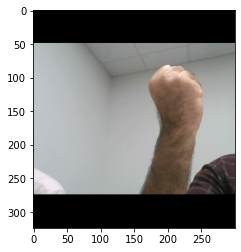

In [50]:
skin_img = './SkinOnlyExample.png'
skin_img_data = load_rgb_image(skin_img)
plt.imshow(skin_img_data)

Loaded Model is: ./Dataset/dtree_additional_images2.sav


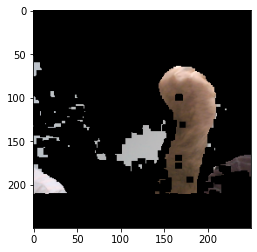

In [51]:
resized = cv2.resize(skin_img_data, (250, 250), interpolation = cv2.INTER_AREA)
processed_skin_img = skin_overlay(resized, model_loc, remove_background=True, aggression=0.5, skin_dilation=2, skin_erosion=4)
plt.imshow(processed_skin_img)